# AST 443 Lab 0
### Kiran Eiden, Jeffrey Michel, Chris DeGrendele


In [1]:
from astropy.io import fits
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import glob
import csv
#import scipy.signal.normalize

In [2]:
def gaussian(x, A, var, mu):
    return A * np.exp(-(x - mu)**2 / (2 * var))
def stas(data):
    return np.mean(data), stats.mode(data)[0][0], np.median(data), np.std(data)

# 4.1 Bias Frames

In [3]:
biases = sorted(glob.glob("data/ccd/*BIAS*"))
biases = list(map(fits.open, biases[:10]))

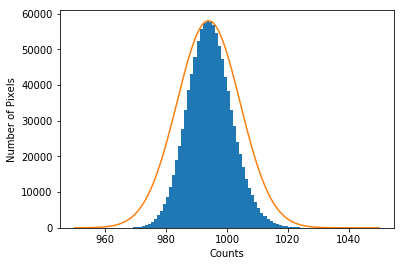

In [4]:
bias0 = biases[0][0]
bias0d = bias0.data.flatten()
bounds = 950, 1050
pmf, bins, _ = plt.hist(bias0d, bins=100, range=bounds);

avg0, mode0, med0, std0 = stas(bias0d)

x = np.linspace(*bounds, num=500)
gaussd = gaussian(x, max(pmf), std0**2, avg0)
plt.plot(x, gaussd);
plt.xlabel("Counts")
plt.ylabel("Number of Pixels");
plt.savefig("plots/biashist.png")

In [5]:
nsd = np.abs((bias0d - avg0) / std0)
trimmed = bias0d[nsd < 3]

pct_bad = 100 * (1 - len(trimmed) / len(bias0d))
print("Q1 4.1")
print(f'The percent cut defined as 3 standard deviations away is: {pct_bad:.3f}%')

Q1 4.1
The percent cut defined as 3 standard deviations away is: 0.040%


In [6]:
elec_noise = bias0.header["EGAIN"] * std0
print("Our measured read noise is:",elec_noise)
print("Manufacturer's manual says 14.8 electrons of read noise. ")

Our measured read noise is: 21.334021034554155
Manufacturer's manual says 14.8 electrons of read noise. 


In [7]:
master_bias = sum([bias[0].data.flatten() for bias in biases]) / len(biases)

avg = np.mean(master_bias)
mode = stats.mode(master_bias)[0][0]
med = np.median(master_bias)
std = np.std(master_bias)

print("Q2 4.1")
print("standard deviation is {}".format(std0))
print("master standard deviation is {}".format(std))
print("This is a factor of {}".format(std/std0))
print("This is not quite {}".format(1/np.sqrt(10)))

Q2 4.1
standard deviation is 10.35632089056027
master standard deviation is 5.381477261079577
This is a factor of 0.5196321471638412
This is not quite 0.31622776601683794


In [8]:
HotBias = list(fits.open("data/ccd/m13.00000031.BIAS.FIT"))
HotBias1 = HotBias[0].data.flatten()

Hotavg, Hotmode, Hotmedian, Hotstd = stas(HotBias1)

trimmed_hot = np.abs((HotBias1-Hotavg)/Hotstd)
HotTrim = HotBias1[trimmed_hot < 3]
pct_bad_hot = 100 * (1 - len(HotTrim) / len(HotBias1))

print(f'The percent cut defined as 3 standard deviations away is: {pct_bad_hot:.3f}%')   
print(f'Compared to colder temperature from earlier: {pct_bad:.3f}%')

The percent cut defined as 3 standard deviations away is: 0.052%
Compared to colder temperature from earlier: 0.040%


# 4.2 Dark Frames

In [9]:
darks = sorted(glob.glob("data/ccd/*DARK*"))
darks = list(map(fits.open, darks[:]))

In [10]:
dark = []
for i in range(len(darks)):
    dark.append(darks[i][0].data.flatten())

In [11]:
Dark_Master = np.array(dark[11:20])
Dark_Master = np.median(Dark_Master, axis=0)

In [12]:
Davg, Dode, Ded, Dtd = stas(Dark_Master)
print("Average: {} \nMode: {} \nMedian: {} \nStandard Deviation: {} \n".format(Davg, Dode, Ded, Dtd))

Average: 1007.0929727554321 
Mode: 1003.0 
Median: 1004.0 
Standard Deviation: 124.45438977066776 



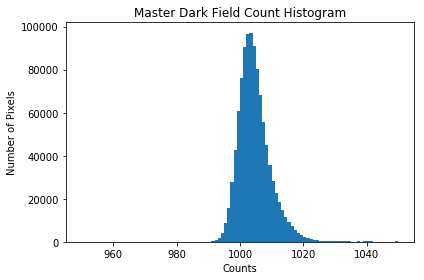

In [13]:
plt.hist(Dark_Master, bins = 100, range=bounds);
plt.xlabel("Counts")
plt.ylabel("Number of Pixels")
plt.title("Master Dark Field Count Histogram")
plt.tight_layout()

plt.savefig("plots/masterdarkhist.png", dpi=1200)

In [14]:
Dark_trim = np.abs(Dark_Master - Davg)/Dtd
Trimmed_Dark_Master = []
Hot_Pixel_Count = 0
for i in range(len(Dark_Master)):
    if Dark_trim[i] < 3:
        Trimmed_Dark_Master.append(Dark_Master[i])
    if Dark_Master[i] > 60000:
        Hot_Pixel_Count = Hot_Pixel_Count+1
pct_good_Dark = 100 * ( len(Trimmed_Dark_Master) / len(Dark_Master))
print("Fraction of pixels included in this cut:", pct_good_Dark)

Fraction of pixels included in this cut: 99.89795684814453


In [15]:
DA, DM, DMe, DS = stas(Dark_Master)
DTA, DTM, DTMe, DTS = stas(Trimmed_Dark_Master)
print("---------Dark_Master---------")
print("Average: {} \nMode: {} \nMedian: {} \nStandard Deviation: {} \n".format(DA, DM, DMe, DS))
print("---------Dark Trimmed Master------")
print("Average: {} \nMode: {} \nMedian: {} \nStandard Deviation: {} \n".format(DTA, DTM, DTMe, DTS))


---------Dark_Master---------
Average: 1007.0929727554321 
Mode: 1003.0 
Median: 1004.0 
Standard Deviation: 124.45438977066776 

---------Dark Trimmed Master------
Average: 1005.4972668414309 
Mode: 1003.0 
Median: 1004.0 
Standard Deviation: 14.037857179166789 



Standard Derviation changes the most due to the trimming because it goes from 124.6 to 15.5

Hot pixels are going to be from the Dark Master and the hot pxels will have counts above 60000

In [16]:
print("There are ", Hot_Pixel_Count, " Hot Pixels. I.e.", round(Hot_Pixel_Count/len(Dark_Master)*100,5), "percent", 
      "of the pixels are hot")

There are  2  Hot Pixels. I.e. 0.00019 percent of the pixels are hot


In [17]:
SDF = dark[11]
SDFA, SDFM, SDFMe, SDFS = stas(dark[0])
SDF_trim = np.abs(dark[0] - SDFA)/SDFS
SDFTrim = []
for i in range(len(SDF)):
    if SDF_trim[i] < 3:
        SDFTrim.append(SDF[i])
pct_good_SDF = 100 * ( len(SDFTrim) / len(SDF))
#SDF stands for single dark frame 

Going from a single dark frame to the master dark frame, the standard deviation increases and the amount of 
pixels thrown out also increases. 

In [18]:
print("Single Dark Frame Standard Deviation=",SDFS)
print("Master Dark Frame Standard Deviation=", Dtd) 
print("Percent of good data for single frame=",pct_good_SDF) 
print("Percent of good data for Master frame=",pct_good_Dark)

Single Dark Frame Standard Deviation= 81.84676429496206
Master Dark Frame Standard Deviation= 124.45438977066776
Percent of good data for single frame= 99.93791580200195
Percent of good data for Master frame= 99.89795684814453


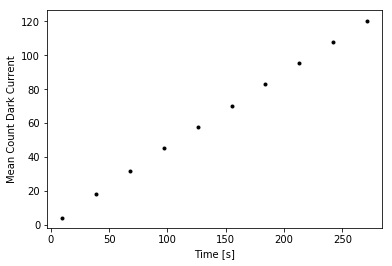

In [19]:
dark_red = [frame - master_bias for frame in dark]
dark_mean = [frame.mean() for frame in dark_red]
dark_mean = dark_mean[:10]

dark_std = [frame.std() / len(frame)**0.5 for frame in dark_red]
dark_std = dark_std[:10]

times = np.array([10,39,68,97,126,155,184,213,242,271])
plt.errorbar(times, dark_mean, yerr=dark_std, fmt="k.")
plt.xlabel("Time [s]")
plt.ylabel("Mean Count Dark Current");

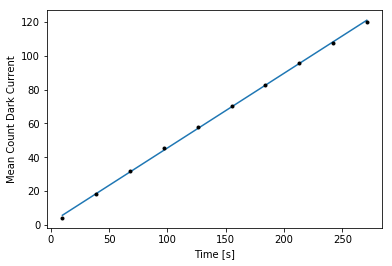

In [20]:
slope, intercept, r_value, p_value, std_err = stats.linregress(times, dark_mean)
plt.errorbar(times, dark_mean, yerr=dark_std, fmt="k.")
plt.plot(times, slope * times + intercept);
plt.xlabel("Time [s]")
plt.ylabel("Mean Count Dark Current");

In [21]:
print("Electrons per pixel per second:", slope)

Electrons per pixel per second: 0.4414221824398863


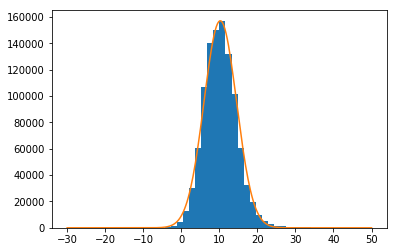

In [22]:
dark_master_red = Dark_Master - master_bias

med = np.median(dark_master_red)
num_sd = np.abs(dark_master_red - med) / med**0.5
dark_master_red = dark_master_red[num_sd < 10]

med = np.median(dark_master_red)
num_sd = np.abs(dark_master_red - med) / med**0.5
dark_master_red = dark_master_red[num_sd < 8]

pmf, bins, _ = plt.hist(dark_master_red, bins=50, range=(-30, 50));
x = np.linspace(-30, 50, num=250)
gauss = gaussian(x, max(pmf), dark_master_red.var(), dark_master_red.mean())
plt.plot(x, gauss);

In [23]:
HotDark = list(fits.open("data/ccd/m13.00000032.DARK.FIT"))
HotDarkData = HotDark[0].data.flatten()

hot_dark_red = HotDarkData - HotBias1
print(f"Hot Dark Current: {hot_dark_red.mean() / 30} electrons per pixel per second")

Hot Dark Current: 15.91317818959554 electrons per pixel per second


In [24]:
SDF_red = SDF - master_bias

med = np.median(SDF_red)
num_sd = np.abs(SDF_red - med) / med**0.5
SDF_red = SDF_red[num_sd < 10]

med = np.median(SDF_red)
num_sd = np.abs(SDF_red - med) / med**0.5
SDF_red = SDF_red[num_sd < 8]

In [25]:
mu = SDF_red.mean()
sd = SDF_red.std()
num_sd = np.abs(SDF_red - mu) / sd
trimmed = SDF_red[num_sd < 3]
print("Single Dark Frame Standard Deviation=", sd)
print("Percent of good data for single frame=", 100*len(trimmed) / len(SDF_red))
mu, sd = dark_master_red.mean(), dark_master_red.std()
num_sd = np.abs(dark_master_red - mu) / mu
print("Dark master reduced sd: ", dark_master_red.std())
print("Dark master reduced pct good: ", 100*sum(num_sd < 3) / len(dark_master_red))

Single Dark Frame Standard Deviation= 7.634482898280238
Percent of good data for single frame= 99.74609632810255
Dark master reduced sd:  4.289529371650235
Dark master reduced pct good:  100.0


# 4.3 Flat Fields

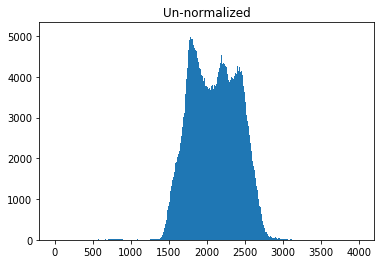

I think the ones over to the left are deadzos?


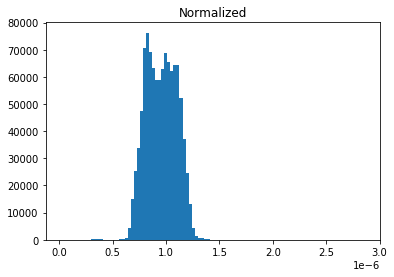

In [51]:
flats = sorted(glob.glob("data/flat/*"))
flats = list(map(fits.open, flats[:])) 
flat = []
for i in range(10):
    flat.append(flats[i][0].data.flatten())
    
master_flat_field = sum(flat[:])/10
plt.hist(master_flat_field, bins = 1000, range = (0,4000));
plt.title("Un-normalized")
plt.show()
print("I think the ones over to the left are deadzos?")

normalized_master_flat_field = master_flat_field / np.sum(master_flat_field)
plt.hist(normalized_master_flat_field, bins = 100);
plt.title("Normalized");
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
plt.show()

4.3.2 - The fraction of the lowest number count to the highest number count is .66 (using ds9)

In [27]:
master_flat_2d = np.reshape(master_flat_field, (1024,1024))

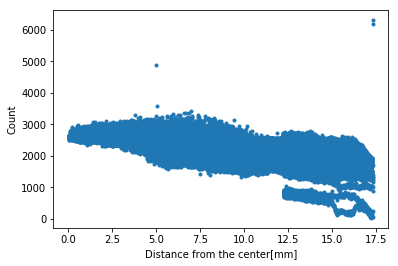

In [28]:
dist = []
sensitivity = [] 
for i in range(len(master_flat_2d)):
    for j in range(len(master_flat_2d)):
        index_space = np.sqrt( (1023/2 - i)**2 + (1023/2 - j)**2 ) #distance from center
        dist.append(index_space * (24.5/1024)) # in mm
        sensitivity.append(master_flat_2d[i][j])
        
plt.scatter(dist, sensitivity, marker='.')
plt.xlabel("Distance from the center[mm]")
plt.ylabel("Count");

4.3.4 - As the distance from the center increases, the observed magnitude would drop

4.3.5 - This would assume the CCD is in the same condition. Probably an ok assumption, but since you are using the flat fields to determine the sensitivity of the pixels with correspondance to each other, the correct answer is probably a no. But I think it actually may be fine to take them later?

In [29]:
for i in range(len(master_flat_2d)):
    for j in range(len(master_flat_2d)):
        if master_flat_2d[i][j] > 4000 or master_flat_2d[i][j] < 500:
            master_flat_2d[i][j] = 0
        else:
            master_flat_2d[i][j] = 1

4.4.2 - I created an array that has 0 in all dark or hot pixels and all other pixels are one. To use this, multiply this array (elementwise) by the data you measure to remove the "bad" pixels.

In [30]:
hdu  = fits.PrimaryHDU(master_flat_field)
hdul = fits.HDUList([hdu])
hdul.writeto('new1.fits' , overwrite=True)
hdu.writeto('new2.fits', overwrite=True)


# 4.5 Spectroscopic Calibration

In [31]:
flatspecs = sorted(glob.glob("data/flat/spec_flat_field.FIT"))
flatspecs = list(map(fits.open, flatspecs[:]))
master_flatspec = flatspecs[0][0].data

In [32]:
master_flatspec.shape

(510, 765)

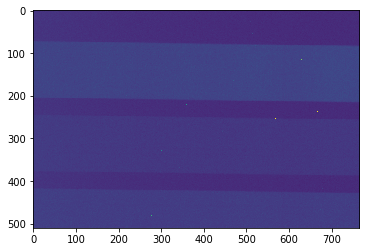

In [33]:
from matplotlib.colors import LogNorm

plt.imshow(master_flatspec, norm=LogNorm(vmin=8e3, vmax=1e4));

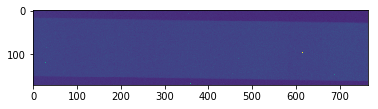

In [34]:
cropped = master_flatspec[55:225, :] #cut out all data we do not want
plt.imshow(cropped, norm=LogNorm(vmin=8e3, vmax=1e4));

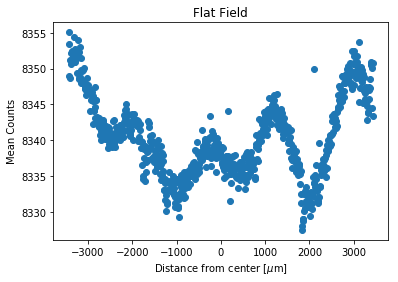

In [35]:
microns_per_pixel = 9
mid = (cropped.shape[1] - 1) / 2 * microns_per_pixel
x = np.linspace(-mid, mid, num=cropped.shape[1])
y = np.mean(cropped, axis=0)

plt.scatter(x, y)

plt.title("Flat Field")
plt.xlabel(r'Distance from center [$\mu$m]')
plt.ylabel('Mean Counts');

Counts as a function of distance from the center

In [36]:
N = 2
fitfunc = np.poly1d(np.polyfit(x,y,N)) #creates a function that takes in a point and fits it to all data

np.sum( (y - fitfunc(x))**2 / y.mean() ) / (len(x)-N-1) #Chi squared

0.001729908660955523

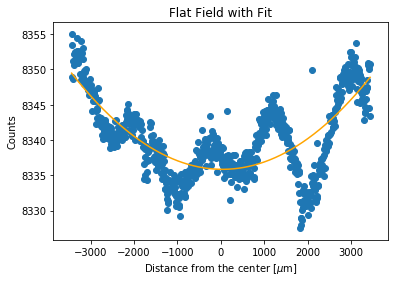

In [37]:
sortedx = np.sort(x)
plt.plot(sortedx,fitfunc(sortedx), color="orange")
plt.scatter(x,y)

plt.title("Flat Field with Fit")
plt.ylabel("Counts")
plt.xlabel(r"Distance from the center [$\mu$m]");
#plot out low-polynomial regression function #bin it

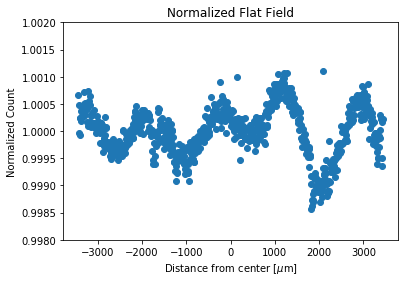

In [38]:
normalized_flatfield = cropped / fitfunc(x)
plt.scatter(x, np.mean(normalized_flatfield, axis=0))
plt.ylim(0.998, 1.002)
plt.title("Normalized Flat Field")
plt.xlabel(r"Distance from center [$\mu$m]")
plt.ylabel(r"Normalized Count");

In [39]:
lamps = sorted(glob.glob("data/flat/spec_lamp.FIT"))
lamps = list(map(fits.open, lamps[:]))
lamp_spec = lamps[0][0].data 

Open and cut the data to get only the 50 micrometer one

In [40]:
lamp_spec = lamp_spec[55:225, :]
normalized_lampfield = lamp_spec / fitfunc(x) #Change the lamp field to deal with sensitivity 
#variations as you increase distance from center

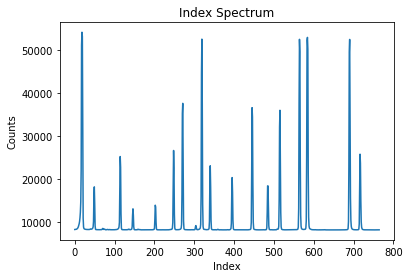

In [41]:
mean = np.mean(lamp_spec, axis=0)
# plot indices versus mean of data
plt.plot(np.arange(lamp_spec.shape[1]),mean)
plt.title("Index Spectrum")
plt.xlabel("Index")
plt.ylabel("Counts");

In [42]:
# Compute intervals that peaks lie within
indices, = np.nonzero(mean > 10000)
jumps = (indices[1:] - indices[:-1]) != 1

lows = list(indices[1:][jumps])
highs = list(indices[:-1][jumps])

lows = [0] + lows
highs = highs + [len(mean)]

In [43]:
# Compute indices of the peaks
indices = [mean[lo:hi].argmax() + lo for lo, hi in zip(lows, highs)]
indices = np.array(indices)

In [44]:
yellow = np.argmax(mean)
reference = np.argmax(mean[40:70]) + 40
Angperpixel = 30 / (reference-yellow)
adjustment = 5852.48 - yellow*Angperpixel 

In [45]:
theory = [5852.49, 5881.49,5944.83,5975.53,6030,6074,6096.16,6143.06,
          6163.59,6217.28,6266.49,6304.79,6334.43,6382.99,6402.25,6506.53,6532.88]
#list of lines that should be there

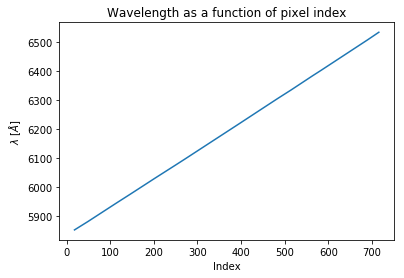

In [46]:
plt.plot(indices,theory)
m, b = np.polyfit(indices,theory,1)
wavelength_v_pixel = np.poly1d((m, b)) #wavelength calibration
plt.title("Wavelength as a function of pixel index")
plt.xlabel('Index')
plt.ylabel(r'$\lambda$ [$\AA$]');

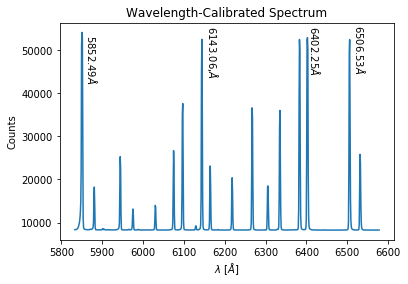

In [47]:
#plt.plot(indices,np.arange(lamp_spec.shape[1])*wavelength_v_pixel(lamp_spec))
plt.plot(wavelength_v_pixel(np.arange(lamp_spec.shape[1])), mean)        

plt.text(5875, 48000, '5852.49$\AA$', ha='center', va='center', rotation=270)
plt.text( 6170.06, 50000, ' 6143.06,$\AA$', ha='center', va='center', rotation=270)
plt.text( 6422, 50340, ' 6402.25$\AA$', ha='center', va='center', rotation=270)
plt.text( 6530.53, 50300, '6506.53$\AA$', ha='center', va='center', rotation=270)
plt.title("Wavelength-Calibrated Spectrum")
plt.xlabel("$\lambda$ [$\AA$]")
plt.ylabel("Counts");

#plot data with wavelength as x axis

In [48]:
disp = m / microns_per_pixel * 1e3
speclen = 6.885 * disp

print(f"Dispersion: {disp:.1f} ang / mm")
print(f"Spectrum Length: {speclen:.1f} ang")

Dispersion: 108.3 ang / mm
Spectrum Length: 745.7 ang


In [49]:
with open("47data.txt", 'w+') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(zip(wavelength_v_pixel(np.arange(lamp_spec.shape[1])), mean))
    #save data

In [50]:
m

0.9747780194475906